# 03 - Convolutional Neural Network Model Training Notebook
Author: George Gorospe, george.gorospe@nmaia.net (updated 1/14/2024)

# In this third notebook, we'll use the the data we previously collected tfo train a Convolutional Neural Network (CNN). 

Training a neural network results in a machine learning model. In this case the resulting model will serve as our pilot for our self-driving car.

In [2]:
# Importing required libraries

### Machine Learning Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

# Custom dataset object library
from xy_dataset import XYDataset

# General Libraries 
import cv2, glob, os, fnmatch
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from ipyfilechooser import FileChooser
from matplotlib.patches import Circle


# Jupyter Laboratory Libraries
import ipywidgets
import traitlets
from IPython.display import display

# Nvidia library for images
from jetcam.utils import bgr8_to_jpeg


### Selecting a Dataset for Training
Use the following folder chooser to select the folder where your dataset is located.

In [3]:
# Create and display a FileChooser widget
fc = FileChooser('/home/racer_core/Datasets')
display(fc)
fc.show_only_dirs = True
# Change the title (use '' to hide)
fc.title = '<b>Choose Dataset for Training</b>'

# Sample callback function
def change_title(chooser):
    chooser.title = '<b>Directory Selected.</b>'

# Register callback function
fc.register_callback(change_title)

FileChooser(path='/home/racer_core/Datasets', filename='', title='', show_hidden=False, select_desc='Select', …

In [4]:
# Inspecting Dataset

# Output from file chooser
DATASET_DIR = fc.selected_path
dataset_folder_name = DATASET_DIR.split("/")[-1]


# Information about the dataset, number of data points and a listing of the data points.
num_files =  len(glob.glob(os.path.join(DATASET_DIR, '*.jpg')))
file_list = fnmatch.filter(os.listdir(DATASET_DIR), '*.jpg')
if num_files > 0:
    print("Dataset found!")
    print("Number of files found in datadset: " + str(num_files))
elif num_files == 0:
  print("No data in selected directory, choose again?")

Dataset found!
Number of files found in datadset: 15053


In [5]:
# Creating our dataset object. This object parses the file names to get the labels for each datapoint

# These transforms adjust the images prior to training to promote robust performance
# Note: Some transforms are commented out they are example of possible transforms to use in the future
TRANSFORMS = transforms.Compose([
    #transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),  # Color Jitter #1
    #transforms.ColorJitter(brightness=1.0, hue=.3), # Color Jitter #2
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # Gaussian Blur #1
    transforms.GaussianBlur(kernel_size=(7), sigma=(0.8)),  # Gaussian Blue #2

    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Sample_Dataset = XYDataset(DATASET_DIR,TRANSFORMS)

Dataset directory exists.
Number of files in datadset: 15053


In [6]:
# Using sklearn to split dataset into training and evaluation subsets

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['evaluate'] = Subset(dataset, val_idx)
    return datasets

# Both "Train" and "Evaluate" datasets are within the datasets list
datasets = train_val_dataset(Sample_Dataset)
print(f"Number of Data Points in Training Dataset: {len(datasets['train'])}")
print(f"Number of Data Points in Evaluate Dataset: {len(datasets['evaluate'])}")

Number of Data Points in Training Dataset: 11289
Number of Data Points in Evaluate Dataset: 3764


In [7]:
# Creating the Dataloaders for both the 'train' and the 'eval' datasets
# Here the datasets ('train' and 'evaluate') are input into DataLoaders
# DataLoaders deliver the data to the training algorithm when requested.
# They deliver the data in 'minibatches' , and reshuffle the data for each epoch
train_dataloader = DataLoader(datasets['train'], batch_size=64, shuffle=True)
test_dataloader = DataLoader(datasets['evaluate'], batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/racer_core/Datasets/ng_class_combined_Jan17/065_000_1054_b38b22ca-b3c6-11ee-ac7a-141333a62981.jpg
Label value (x): 64


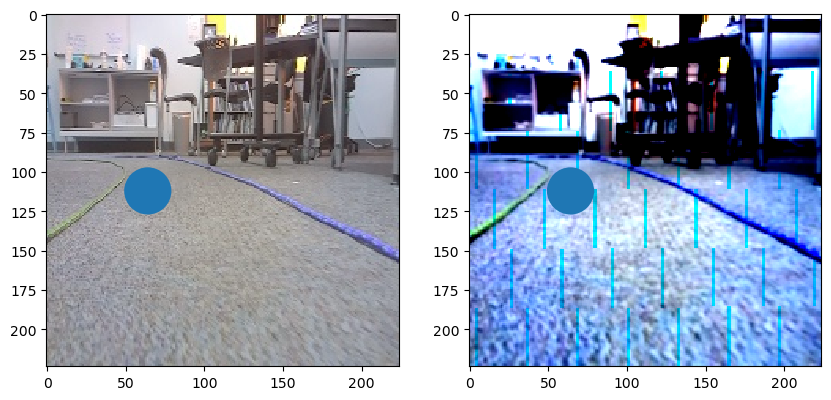

In [8]:
# Plotting an example of the data from the train loader

# Create a figure for both images
fig = plt.figure(figsize= (10, 10))

# Create a subplot for the array of images
ax = fig.add_subplot(1, 2, 1)

# Get an image, list of annotations and labels from the train dataloader
train_image, ann, train_labels = next(iter(train_dataloader))

# Getting the label for the image
x = train_labels[0].numpy()[0]
x = int(224 * (x / 2.0 + 0.5))

# Reading the raw image from file
file_path = ann['image_path'][0]
print(file_path)
print(f"Label value (x): {x}")
img = cv2.imread(file_path)

# Plotting the raw image w/ label
circ = Circle((x,112),15)
ax.add_patch(circ)
ax.imshow(img)

# Getting the transformed image from the dataloader (all images on the
train_image = train_image.numpy()[0]
train_image = np.moveaxis(train_image, 0, -1)

# Plotting the transformed image w/ label
ax = fig.add_subplot(1, 2, 2)
circ = Circle((x,112),15)
ax.add_patch(circ)
ax.imshow(train_image)

## Training the CNN on the Selected Dataset
Next, we'll setup the training algorithm for our machine learning model.
As we prepare to train our model we need to make choices about the way we'll train it.
These choices can impact how long it takes to train the model and the overall accuracy of the model.

The user-set parameters of the training algorithm are often called "Hyper-Parameters"
You can set your hyper parameters below, make sure to track which setting you used for your training!

In [12]:
# Set Training Hyper Parameters:

########## [ACTION REQUIRED] Set name for new machine learning model #################
model_file_name = "ResnetFinal_ng_large_model_test_01.pth"
training_notes = "This training is part of an experiment in the use of large models. In this case I've freezed most of the layers."


# Number of training epochs:
epochs = 4

# Data loader batch size:
BATCH_SIZE = 64

# Model Output
output_dim = 2

######### Select a Machine learning model structure (Neural Network) ###########
# Resnet 18
#model = torchvision.models.resnet18(pretrained=True)
# Resnet 34
model = torchvision.models.resnet34(pretrained=True)
# Resnet 50
#model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
# MobileNet V2
#model = torchvision.models.mobilenet_v2(pretrained=True)
# MobileNet V3
#model = torchvision.models.mobilenet_v3_large(pretrained=True)


# If you wanted to train fewer of the layers (freeze some layers)
#Freeze all of the weights in ResNet18
for param in model.parameters():
  param.requires_grad = False

# Adding a fully connected layer to the top/head of the model
model.fc = torch.nn.Linear(512, output_dim)

# Model optimizer:
optimizer = torch.optim.Adam(model.parameters())

#Loading a GPU if avaliable and otherwise a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
def training_and_evaluation(epochs):
  # Training Timing
  start_time = datetime.now()

  # Writing training details to training log
  f = open("/home/racer_core/Models/training_log.txt", "a")
  f.write("\n")
  dt_string = start_time.strftime("%m/%d/%Y %H:%M:%S")
  f.write(f"Training Report: {dt_string} \n")
  f.write(f"Selected Dataset: {dataset_folder_name}, Number Data Points: {num_files}\n")
  f.write(f"Model: {model.__class__.__name__}{34}, Epochs: {epochs}, Batch Size: {BATCH_SIZE}\n")
  f.write(f"Training Notes: {training_notes}\n")
  f.write(f"Transforms used in this training: {TRANSFORMS}\n")
  # Remaining details will be written at the end of the training

  ############# Initiating Training Process ##############
  # First set model to train mode
  model.train()

  print("Starting training process ...")
  # Start training process dependent on number of epochs
  while epochs > 0:
    print("######### Epoch: " + str(epochs) + " #########")
    # Index
    i = 0
    sum_loss = 0.0
    error_count = 0.0

    # Training Loop
    # Process each batch of data points in the train loader
    for images, category_idx, xy in iter(train_dataloader):
      # send data to device
      images = images.to(device)
      xy = xy.to(device)

      # zero gradients of parameters
      optimizer.zero_grad()

      # execute model to get outputs
      outputs = model(images)

      # compute MSE loss over x, y coordinates for associated categories
      loss = 0.0
      loss += torch.mean((outputs - xy)**2)
      #for batch_idx, cat_idx in enumerate(list(category_idx.flatten())):
      #    loss += torch.mean((outputs[batch_idx][2 * cat_idx:2 * cat_idx+2] - xy[batch_idx])**2)
      #loss /= len(category_idx)

      # run backpropogation to accumulate gradients
      loss.backward()

      # step optimizer to adjust parameters
      optimizer.step()

      # increment progress
      # NO TRAINING ACCURACY: no correct answer for regression, only loss
      #count = len(category_idx.flatten())
      #i += count
      i += len(xy)
      sum_loss += float(loss)
      #progress_widget.value = i / len(dataset)
      #loss_widget.value = sum_loss / i


      print("Mean Square Error (MSE): " + str(sum_loss/i))

    #sum_loss.append(totalLoss)
    #print(f"Training Accuracy: {testAccuracy / len(training)}")


    # Evaluation Loop
    i = 0
    evaluation_loss = 0.0
    for images, category_idx, xy in test_dataloader:

        # Put the model into evaluation mode
        model.eval()

        # send data to device
        images = images.to(device)
        xy = xy.to(device)

        # execute model to get outputs
        outputs = model(images)

        # compute MSE loss over x, y coordinates for associated categories
        loss = 0.0
        loss += torch.mean((outputs - xy)**2)
        i += len(xy)
        evaluation_loss += float(loss)
    print(f"Validation Test Mean Square Error (MSE): {evaluation_loss / i}")
    #Save our model for each epoch
    #torch.save(model.state_dict(), file)

    # End of the current epoch
    epochs = epochs -1
  end_time = datetime.now()

  # get the execution time
  elapsed_time = end_time - start_time
  training_duration_time_formatted = str(elapsed_time)
  print('Execution time:', training_duration_time_formatted)


  f.write(f"Final model evaluation loss: {evaluation_loss/i}\n")
  f.write(f"Total training & evaluation time: {training_duration_time_formatted}\n")
  f.write("\n")
  f.close()

  return model #trainLoss, validationLoss, model

# START TRAINING
model = training_and_evaluation(epochs)

# SAVE TGHE MODEL TO FILE
model_folder = "/home/racer_core/Models/"
model_file_path = model_folder + model_file_name
torch.save(model.state_dict(), model_file_path)
print(f"Saved new model as: {model_file_path}")


Starting training process ...
######### Epoch: 4 #########
Mean Square Error (MSE): 0.011210545897483826
Mean Square Error (MSE): 0.007458894280716777
Mean Square Error (MSE): 0.005808286834508181
Mean Square Error (MSE): 0.005504223867319524
Mean Square Error (MSE): 0.005477962177246809
Mean Square Error (MSE): 0.0053373844518015785
Mean Square Error (MSE): 0.005066468779529844
Mean Square Error (MSE): 0.004748244886286557
Mean Square Error (MSE): 0.0045119772096061045
Mean Square Error (MSE): 0.004308921075426042
Mean Square Error (MSE): 0.004130752228031104
Mean Square Error (MSE): 0.0040280901788113015
Mean Square Error (MSE): 0.003909939398559241
Mean Square Error (MSE): 0.0038193775939622094
Mean Square Error (MSE): 0.003733526449650526
Mean Square Error (MSE): 0.003647908743005246
Mean Square Error (MSE): 0.003549435641616583
Mean Square Error (MSE): 0.0034367640619166195
Mean Square Error (MSE): 0.0033366694789085734
Mean Square Error (MSE): 0.0032591596071142705
Mean Square Er

### Optimizing the Machine Learning Model to Run on the Robot
In this final step to the training process, we'll optimize the model using a special library from Nvidia.
This optimization enables us to use our new machine learning model at a fast frame rate.

In [ ]:
#model = torchvision.models.resnet18(pretrained=False)
#model.fc = torch.nn.Linear(512, 2 * len(CATEGORIES))
#model = model.cuda().eval().half()
#model.load_state_dict(torch.load('/home/racer_core/Models/ResnetFinal_ng_combined.pth'))

from torch2trt import torch2trt

data = torch.zeros((1, 3, 224, 224)).cuda().half()

model_trt = torch2trt(model, [data], fp16_mode=True)

torch.save(model_trt.state_dict(), '/home/racer_core/Models/optimized_models/ResnetFinal_ng_stability_test_02_TRT.pth')
